### Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
3. Какой столбец содержит целевую переменную? Запишите его название.
4. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [19]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline

## Предобработка данных

In [78]:
# Загрузка
train = pd.read_csv('features.csv', index_col='match_id')
test = pd.read_csv('features_test.csv', index_col='match_id')


In [81]:
# Удаление признаков из будущего
train.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)

In [82]:
# Выделение целевой переменной
y = train.radiant_win
X = train.drop('radiant_win', axis=1)

### Целевая переменная - radiant win

### Пропуски

In [83]:
description = X.describe()
rows = len(X)
counts = description.T['count']
counts_na = counts[counts < rows]
counts_na.sort_values().apply(lambda c: (rows - c) / rows)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
Name: count, dtype: float64

* **first_blood_player2** - В 45% случаев первую кровь проливает один игрок;
* **first_blood_team** - в 20% случае в первые пять минут никто не пострадал;
* ... и т.д.

### Замена пропусков

In [84]:
X.fillna(0, inplace=True)

In [85]:
# Удаление всех категориальных признаков
del X['lobby_type']
for n in range(1, 6):
    del X['r{}_hero'.format(n)]
    del X['d{}_hero'.format(n)]

In [54]:
X.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,5,2098,1489,20,0,0,7,3,842,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,4,1188,1033,9,0,1,12,4,1596,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,4,1319,1270,22,0,0,12,3,1314,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,4,1779,1056,14,0,0,5,2,539,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,4,1431,1090,8,1,0,8,2,629,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


### Градиентный бустинг

In [20]:
kf = KFold(y.size, n_folds=5, shuffle=True, random_state=42)

In [21]:
# Подбор оптимального числа деревьев
results = []
trees_num = [10, 20, 30, 50, 100, 250]
for trees in trees_num:
    print( 'Number of trees processing: ', str(trees))
    model = GradientBoostingClassifier(n_estimators=trees, random_state=42)
    start_time = datetime.datetime.now()
    model_res = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
    print('Time spent:', datetime.datetime.now() - start_time)
    print(model_res)
    results.append(np.mean(model_res))

Number of trees processing:  10
Time spent: 0:00:30.363666
[ 0.66383799  0.66635457  0.66360047  0.66529818  0.66516226]
Number of trees processing:  20
Time spent: 0:00:52.235595
[ 0.68047922  0.68272733  0.67969876  0.68385967  0.6855512 ]
Number of trees processing:  30
Time spent: 0:01:10.961868
[ 0.68792499  0.68934663  0.68722173  0.69101923  0.69283583]
Number of trees processing:  50
Time spent: 0:01:54.319201
[ 0.69658233  0.69746892  0.69492935  0.69865049  0.69975948]
Number of trees processing:  100
Time spent: 0:03:43.831524
[ 0.70494811  0.70577018  0.7045066   0.70785492  0.70861247]
Number of trees processing:  250
Time spent: 0:09:00.601277
[ 0.71231771  0.71219364  0.7115492   0.71483688  0.71511696]


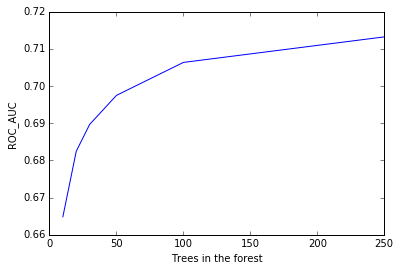

In [23]:
plt.plot(trees_num, results)
plt.xlabel('Trees in the forest')
plt.ylabel('ROC_AUC')
plt.show()

С ростом числа деревьев в лесу увеличивается его roc-auc на кросс-валидации (~0,71 при 100 деревьях).

### Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).
4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
kf = KFold(y.size, n_folds=5, shuffle=True, random_state=42)

In [29]:
def plot_lambda_scores(pow_range, scores):
    plt.plot(pow_range, scores)
    plt.xlabel('log(lambda)')
    plt.ylabel('roc_auc')
    plt.show()

def test_model_lambda(X, y, lambd):
    print('lambda =', str(lambd))
    model = LogisticRegression(C=lambd, random_state=42, n_jobs=-1)
    return cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
    
def test_model(X, y):
    scores = []
    pow_range = range(-5, 6)
    lambda_range = [10 ** power for power in pow_range]
    for lambd in lambda_range:
        start_time = datetime.datetime.now()
        model_scores = test_model_lambda(X, y, lambd)
        print(model_scores)
        print('Time spent:', datetime.datetime.now() - start_time)   
        scores.append(np.mean(model_scores))

    plot_lambda_scores(pow_range, scores)
    
    max_score = max(scores)
    max_score_index = scores.index(max_score)
    return lambda_range[max_score_index], max_score
    

In [31]:
import warnings
warnings.filterwarnings('ignore')

lambda = 1e-05
[ 0.69301062  0.69476367  0.69562224  0.69507489  0.69702951]
Time spent: 0:00:06.735862
lambda = 0.0001
[ 0.70936502  0.71042199  0.71168956  0.71168269  0.71353648]
Time spent: 0:00:09.206811
lambda = 0.001
[ 0.71434804  0.71581532  0.71629769  0.7168852   0.71853275]
Time spent: 0:00:09.808346
lambda = 0.01
[ 0.71450425  0.71622052  0.71627998  0.71725088  0.71854131]
Time spent: 0:00:10.728461
lambda = 0.1
[ 0.71448206  0.71620991  0.71622569  0.71726917  0.71848436]
Time spent: 0:00:12.244230
lambda = 1
[ 0.71447768  0.71620628  0.7162209   0.71727019  0.71847678]
Time spent: 0:00:14.194064
lambda = 10
[ 0.7144767   0.71620645  0.71621968  0.71727122  0.71847581]
Time spent: 0:00:12.345737
lambda = 100
[ 0.71447671  0.71620624  0.71621963  0.71727119  0.71847568]
Time spent: 0:00:11.446651
lambda = 1000
[ 0.71447667  0.71620624  0.71621966  0.71727119  0.71847569]
Time spent: 0:00:12.130603
lambda = 10000
[ 0.71447667  0.71620627  0.71621961  0.71727117  0.71847569]

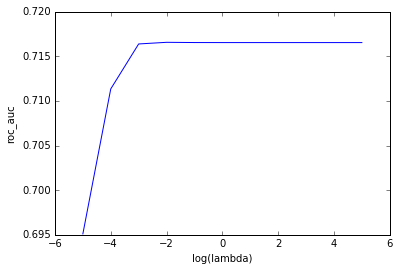

In [32]:
C, score = test_model(X, y);

### Мешок слов

In [92]:
# 112 — количество различных героев в выборке
X_pick = np.zeros(X.shape[0], 112)

for i, match_id in enumerate(X.index):
    for p in range(5):
        X_pick[i, train.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, train.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [93]:
X_pick = pd.DataFrame(X_pick)

In [116]:
X_1 = X.reset_index()

In [117]:
X_new = pd.concat([X_1, X_pick], axis=1)

lambda = 1e-05
[ 0.69606555  0.69836358  0.6987767   0.68791097  0.69989145]
Time spent: 0:00:10.986859
lambda = 0.0001
[ 0.710362    0.71155529  0.71251445  0.7132271   0.71419066]
Time spent: 0:00:11.336902
lambda = 0.001
[ 0.70733925  0.70861595  0.70948187  0.71005213  0.71110485]
Time spent: 0:00:11.097897
lambda = 0.01
[ 0.70700783  0.70828926  0.70914472  0.70970107  0.71076434]
Time spent: 0:00:11.075165
lambda = 0.1
[ 0.70697322  0.708256    0.70910958  0.70966427  0.71073001]
Time spent: 0:00:10.976558
lambda = 1
[ 0.70697     0.70825198  0.70910606  0.70966082  0.71072657]
Time spent: 0:00:10.927907
lambda = 10
[ 0.70696956  0.70825192  0.7091059   0.70966042  0.7107263 ]
Time spent: 0:00:10.895928
lambda = 100
[ 0.70696949  0.70825193  0.70910585  0.70966037  0.71072628]
Time spent: 0:00:11.351811
lambda = 1000
[ 0.70696949  0.70825192  0.70910583  0.70966036  0.71072629]
Time spent: 0:00:11.567220
lambda = 10000
[ 0.70696948  0.70825191  0.70910582  0.70966036  0.71072628]

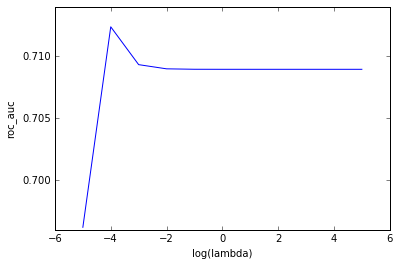

In [120]:
kf = KFold(y.size, n_folds=5, shuffle=True, random_state=42)
C, score = test_model(X_new, y)

In [121]:
print(C)
print(score)

0.0001
0.71236989982


In [122]:
## что-то неправильно сделалось. Очень лениво отлаживать, сорян